In [54]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tasks

- Do a tfidf transform
    - Is there a better way to process the text?
    - What about other variables in the dataset?
- Do a label transform
- find other models to run for this problem
- Run different regions with papermill
- Use yellowbrick to run some tests
    - !!! Important: [Learning Curve](https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html)

In [38]:
%autoreload 2
import pandas as pd
import sys
import xgboost
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import permutation_test_score
from joblib import dump, load

2022-07-12 15:42:10,554 Running ML Training with target = gaul


In [39]:
names_data = pd.read_feather("/home/am2497/uganda-uber-classifier/data/processed/after_stata_comp_region_gaul.feather")

In [ ]:
# process names data

In [21]:
dump(tfidf, "ml-output/model_dump/trained_models/tfidf_boom.joblib")

dump(labels, f"ml-output/model_dump/trained_models/label_encoder_kingdom_{target}.joblib")

2022-07-12 12:56:56,250 Dumping pre-processors


['ml-output/model_dump/trained_models/label_encoder_kingdom.joblib']

In [46]:

model = xgboost.XGBClassifier()

X = tfidf.fit_transform(<feature_col>)
y = labels.fit_transform(<label_col>)
groups = <data transformation>

skf = StratifiedGroupKFold(n_splits=10) 
splitter = skf.split(X, y, groups=groups)



2022-07-12 15:44:17,968 Creating model


In [22]:

calibrated_model = CalibratedClassifierCV(model, 
                                            cv=splitter, 
                                            method='isotonic', # better than platt, but let's do both
                                            n_jobs = 5, # only works for sklearn >= 0.24
                                            ensemble= True) # dont need the average probabilities

calibrated_model.fit(X, y)
        
path = f"ml-output/model_dump/trained_models/xgb/calibration/model_{target}.joblib"

dump(calibrated_model, path)



2022-07-12 12:57:52,316 Fitting Model
2022-07-12 12:59:37,858 Dumped calibrated estimator to ml-output/model_dump/trained_models/xgb/calibration/model.joblib


In [25]:
# Run same thing on dummy classifier

dummy_model = DummyClassifier(
    strategy = 'stratified'
)

#run calibrated classifier on features
calibrated_dummy_model = CalibratedClassifierCV(dummy_model, 
                                            cv=splitter, 
                                            method='isotonic', # better than platt, but let's do both
                                            n_jobs = 5, # only works for sklearn >= 0.24
                                            ensemble= True) # dont need the average probabilities

calibrated_dummy_model.fit(X, y)
        
path = f"ml-output/model_dump/trained_models/xgb/calibration/dummy_model_{target}.joblib"

dump(calibrated_dummy_model, path)


2022-07-12 13:00:55,307 Creating Dummy model
2022-07-12 13:00:55,308 Fitting Dummy Model
2022-07-12 13:00:55,544 Dumped calibrated estimator to ml-output/model_dump/trained_models/xgb/calibration/dummy_model.joblib


/home/am2497/miniconda3/envs/uganda-uber/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [41]:
# Load models after training

calibrated_model = load(f"ml-output/model_dump/trained_models/xgb/calibration/model_{target}.joblib")
calibrated_dummy_model = load(f"ml-output/model_dump/trained_models/xgb/calibration/dummy_model_{target}.joblib")


### Plotting Feature Importances

2022-07-12 13:01:50,759 Generating Importance Plot for SMOTE
2022-07-12 13:01:51,888 findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-07-12 13:01:51,889 findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
2022-07-12 13:01:51,936 findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-07-12 13:01:51,938 findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
2022-07-12 13:01:51,978 findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-07-12 13:01:51,979 findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


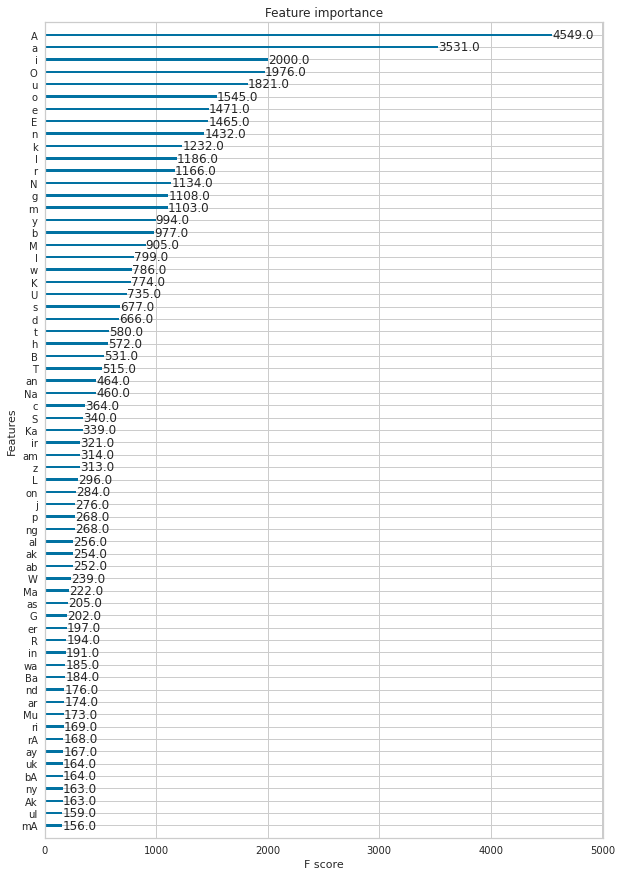

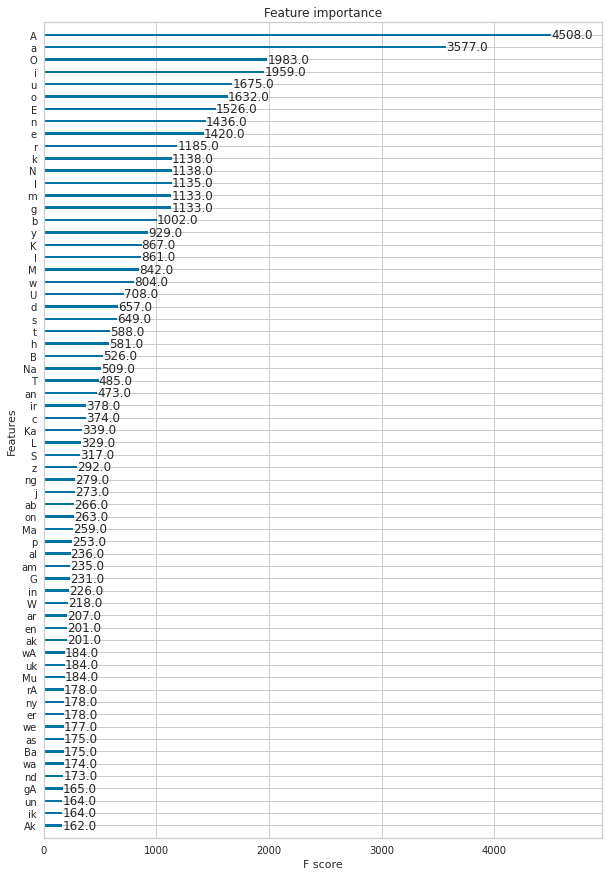

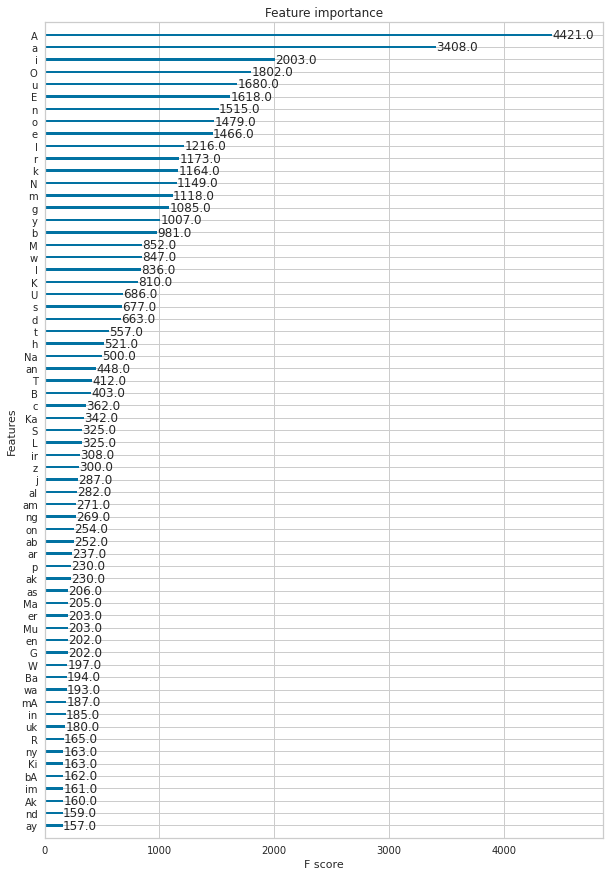

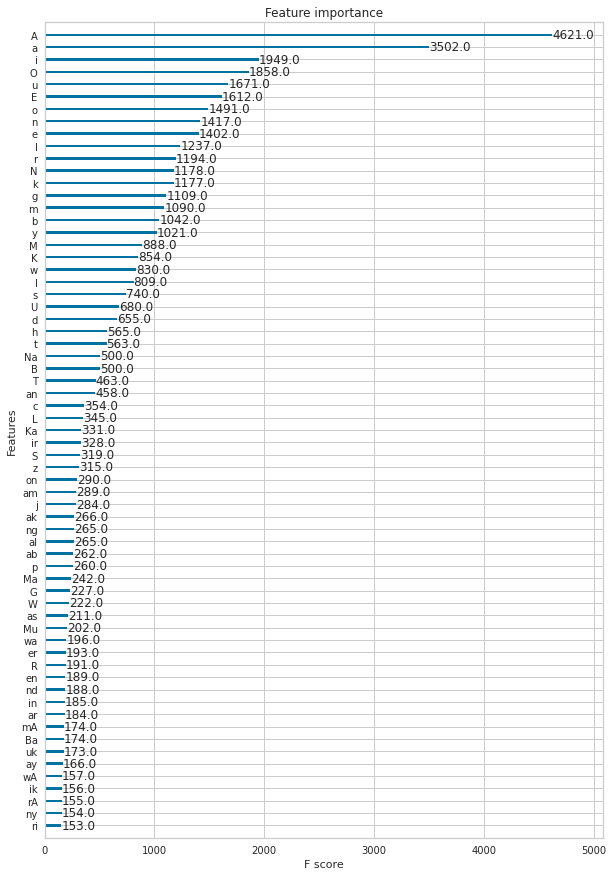

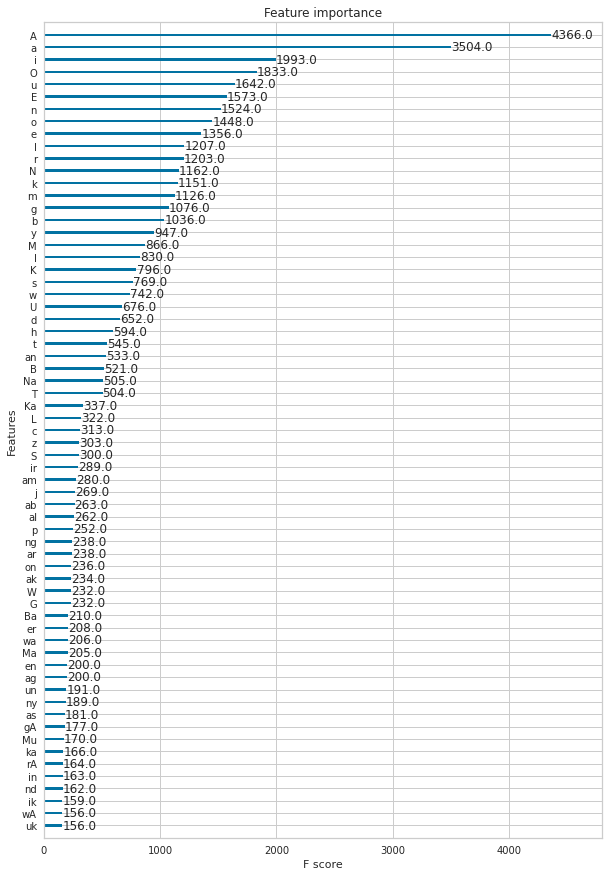

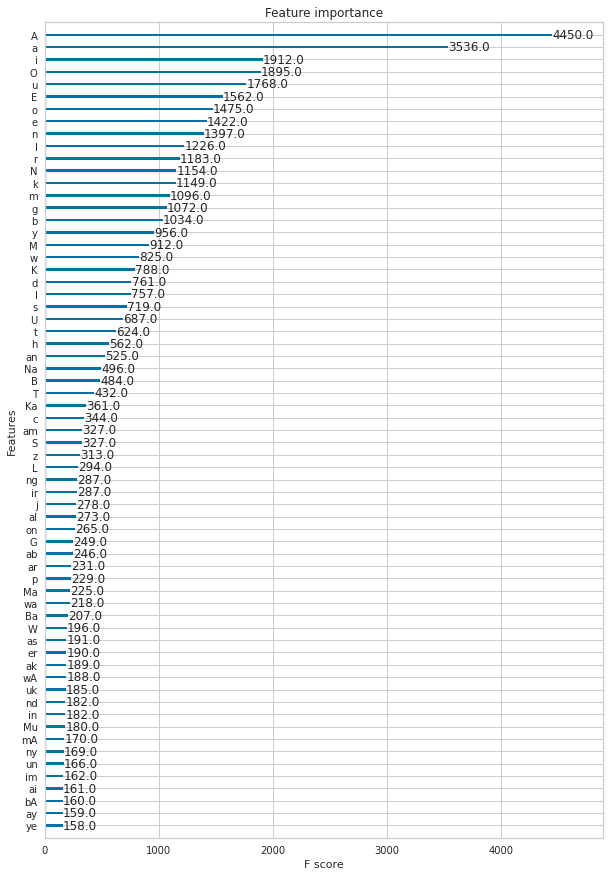

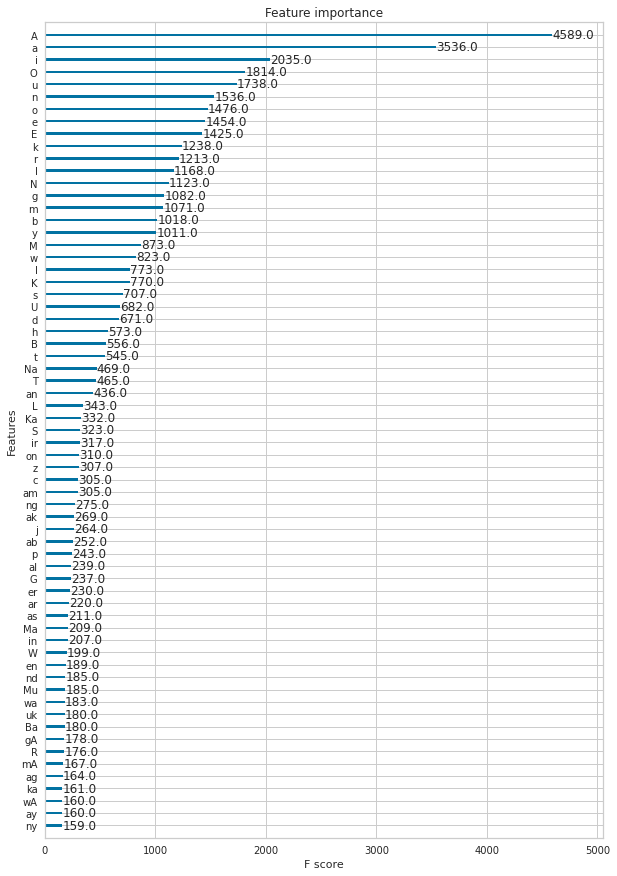

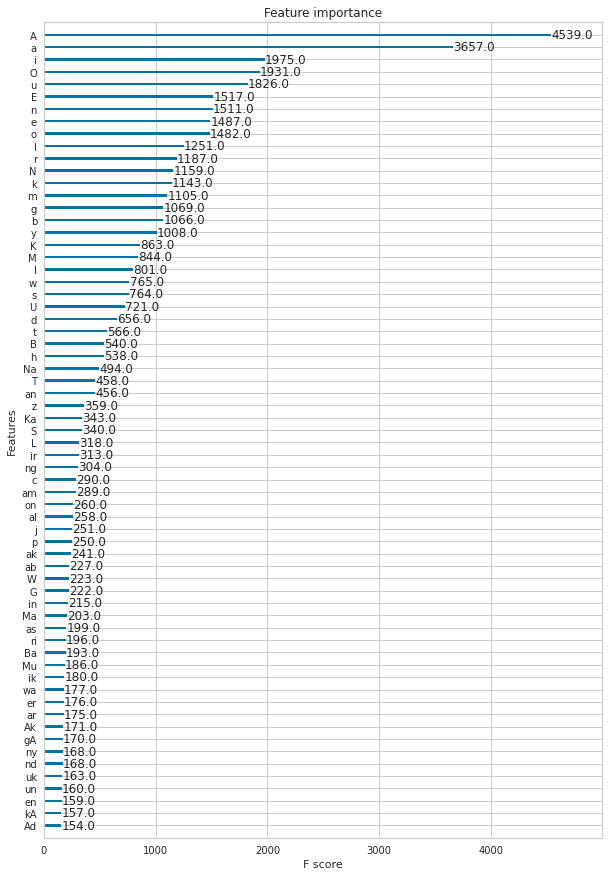

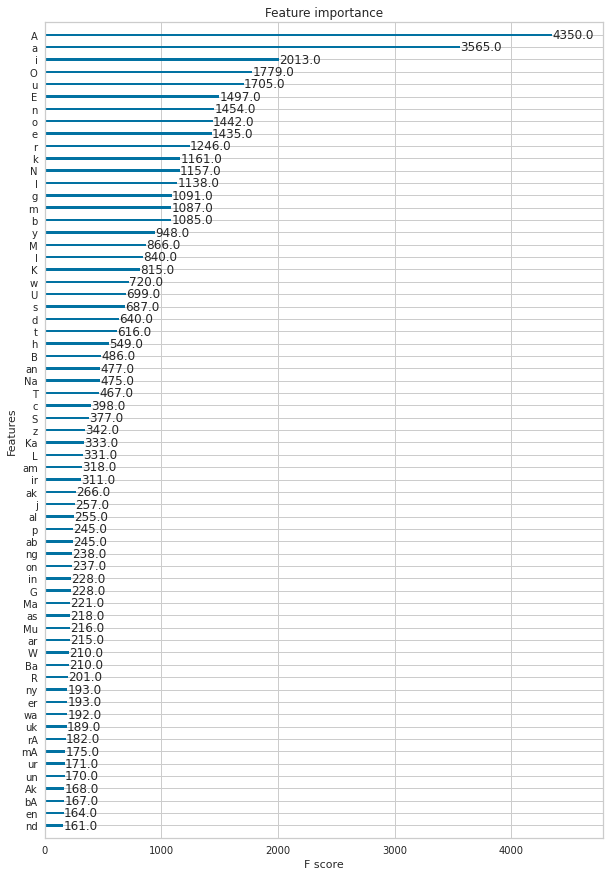

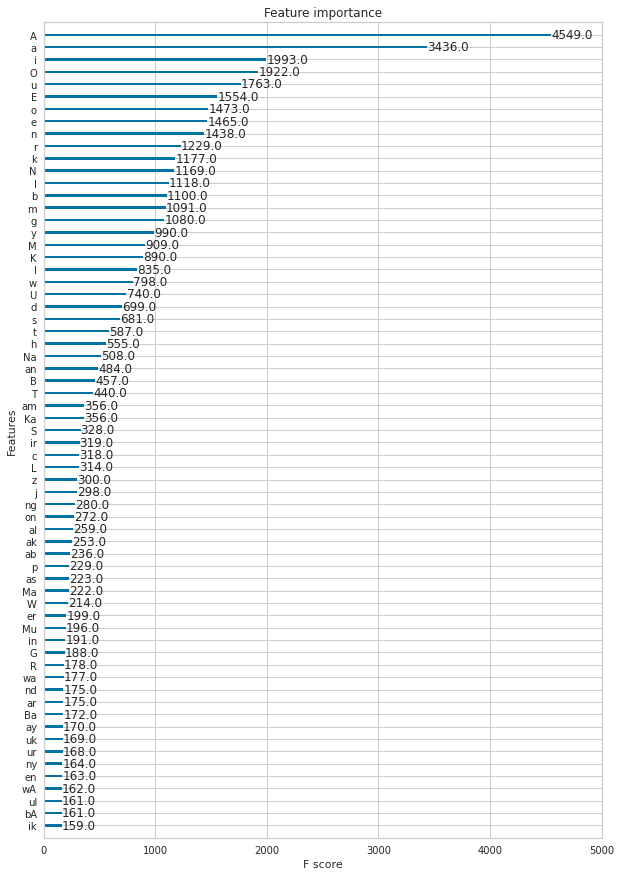

In [27]:
for c in range(10):
    fig, ax = plt.subplots(figsize=(10,15))

    xgboost.plot_importance(calibrated_model.calibrated_classifiers_[c].base_estimator, max_num_features=65, ax=ax)

    ax.set_yticklabels(tfidf.get_feature_names_out()[[int(i.get_text()[1::]) for i in ax.get_yticklabels()]]);

    plt.savefig(f"../figures/importance_plot_{c}_{target}.png", dpi=300)

In [34]:

score_dict = {'Random Classifier' : [], 'Frequency Table' : [], 'Calibrated XGBoost Classifier' : []}

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=50)

for train, test in splitter:
    print("calibrated model:", calibrated_model.score(X[test], y[test]))
    print("dummy model:", calibrated_dummy_model.score(X[test], y[test]))
    
    score_dict['Random Classifier'].append(calibrated_dummy_model.score(X[test], y[test]))
    score_dict['Calibrated XGBoost Classifier'].append(calibrated_model.score(X[test], y[test]))
    
score_df = pd.DataFrame(score_dict, index=[f'CV Fold {i}' for i in range(1,11)])

2022-07-12 13:04:58,129 Generating Comparison Table
INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Frequency model: 0.8231768231768232
calibrated model: 0.8201798201798202
dummy model: 0.15784215784215785
Frequency model: 0.837
calibrated model: 0.828
dummy model: 0.158
Frequency model: 0.831
calibrated model: 0.821
dummy model: 0.158
Frequency model: 0.817
calibrated model: 0.811
dummy model: 0.157
Frequency model: 0.842
calibrated model: 0.837
dummy model: 0.157
Frequency model: 0.8358358358358359
calibrated model: 0.8298298298298298
dummy model: 0.15815815815815815
Frequency model: 0.822
calibrated model: 0.817
dummy model: 0.157
Frequency model: 0.813
calibrated model: 0.805
dummy model: 0.157
Frequency model: 0.825
calibrated model: 0.819
dummy model: 0.157
Frequency model: 0.836
calibrated model: 0.827
dummy model: 0.158


In [35]:
cv_results_table = score_df.T.assign(**{'CV Fold Mean' : lambda df: df.mean(axis=1)}).T.applymap(lambda x: f"{x:.3f}").style.to_latex(caption='Results Cross-validation Folds of XGBoost Classifier Compared against a Random Classifier', label='fig-cvresults')

with open(f"../tables/cvresults_{target}_training.tex", 'w') as f:
    f.write(cv_results_table)

### Permutation Test

In [58]:
score, perm_scores, pvalue = permutation_test_score(
    calibrated_model, X, y, scoring="accuracy", cv=splitter, n_permutations=1000, n_jobs=10
)

2022-07-12 20:49:58,263 Running Permutation Test...


IndexError: index (49999) out of range

In [ ]:
# Save permutation scores for later

dump((score, perm_scores, pvalue), f'data/perm_score_data_{target}.joblib')

['data/perm_score_data.joblib']